In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import average_precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from src.files_io import load_raw_mailout_datasets, download_and_extract_raw_datasets
from src.preprocessing import preprocess_data

/home/patrick/.cache/pypoetry/virtualenvs/udacity-capstone-EsMFQbru-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
"""
Load & Preprocess Data
- to prevent naming irritations, we name the provided test dataset "competition", because it is used to compete with the model results
"""

'\nLoad & Preprocess Data\n- to prevent naming irritations, we name the provided test dataset "competition", because it is used to compete with the model results\n'

In [3]:
download_and_extract_raw_datasets()

Raw Datasets already exists.


In [4]:
train_raw, competition_raw = load_raw_mailout_datasets()

Mailout datasets loaded.


In [5]:
train_response = train_raw["response"]

In [6]:
train_preprocessed, competition_preprocessed = preprocess_data(train_raw, competition_raw, ("train", "competition_test"))

Metadata loaded.
Metadata rectified.
Feature config loaded.

Start cleaning train dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7962 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_kind4, extsel992, geburtsjahr, kba05_baumax, kk_kundentyp
Replaced missing values in 136 features.
Extracted decade and cultural orientation as separate features.
Extracted wealth and life phase as separate features.
Removed 51 redundant features.
Removed 24 uncertain features.

Start cleaning competition_test dataset...
Removed 3 irrelevant features.
Converted 324 unknown values from the meta information to null in the dataset.
Converted 8 invalid values to null in the dataset.
Removed 7841 records with over 33.0% missing feature values.
Removed 6 features with over 20.0% missing values:
alter_kind3, alter_

In [7]:
train_preprocessed = train_preprocessed.join(train_response, how="left")

assert train_preprocessed["response"].isnull().sum() == 0

In [8]:
"""
# Class Imbalance
- high imbalance (just 1% are responders)
"""

'\n# Class Imbalance\n- high imbalance (just 1% are responders)\n'

In [9]:
train_preprocessed["response"].value_counts(normalize=True)

response
0    0.987571
1    0.012429
Name: proportion, dtype: float64

In [10]:
"""
# Split Dataset
- stratified sampling due to class imbalance
- to avoid data leakage and ensure unbiased evaluation, we use a validation set for early stopping and hyperparameter tuning and a separate test set (data that the model has never seen before) for the final evaluation:
  - training set: for model training
  - validation set: for early stopping and hyperparameter tuning
  - test set: for final evaluation
"""

'\n# Split Dataset\n- stratified sampling due to class imbalance\n- to avoid data leakage and ensure unbiased evaluation, we use a validation set for early stopping and hyperparameter tuning and a separate test set (data that the model has never seen before) for the final evaluation:\n  - training set: for model training\n  - validation set: for early stopping and hyperparameter tuning\n  - test set: for final evaluation\n'

In [11]:
train, validation_test = train_test_split(train_preprocessed, test_size=0.3, random_state=10, stratify=train_preprocessed["response"])

validation, test = train_test_split(validation_test, test_size=0.5, random_state=10, stratify=validation_test["response"])

del validation_test

In [12]:
"""
# Train XGBoost Classification Model
- binary classification model (person will respond: yes or no)
- gradient boosting decision trees are highly effective and very successful in solving various ml problems
- XGBoost can appropriately handle class imbalance with the `scale_pos_weigth` parameter
- evaluation metric: precision recall auc
  - focuses only on the performance for the positive class (responders), ignoring the abundance of negatives, making it much more informative than ROC AUC when dealing with highly imbalanced datasets
  - highlights how well the model identifies true positives without being overwhelmed by the majority class
  - it ignores true negatives, so imbalanced negatives don't dilute the score
  - summarizes the model"s performance across all possible thresholds (unlike the f1 score)
  - mail costs are not that much, so our focus is not to miss a potential customer
"""

'\n# Train XGBoost Classification Model\n- binary classification model (person will respond: yes or no)\n- gradient boosting decision trees are highly effective and very successful in solving various ml problems\n- XGBoost can appropriately handle class imbalance with the `scale_pos_weigth` parameter\n- evaluation metric: precision recall auc\n  - focuses only on the performance for the positive class (responders), ignoring the abundance of negatives, making it much more informative than ROC AUC when dealing with highly imbalanced datasets\n  - highlights how well the model identifies true positives without being overwhelmed by the majority class\n  - it ignores true negatives, so imbalanced negatives don\'t dilute the score\n  - summarizes the model"s performance across all possible thresholds (unlike the f1 score)\n  - mail costs are not that much, so our focus is not to miss a potential customer\n'

In [13]:
# negative_samples = train[train["response"] == 0]
# positive_samples = train[train["response"] == 1]
#
# positive_upsampled = resample(
#     positive_samples,
#     replace=True,
#     n_samples=len(negative_samples),
#     random_state=42
# )
#
# train = pd.concat([negative_samples, positive_upsampled], ignore_index=True)

In [14]:
def split_features_and_response(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    y = df["response"]
    X = df.drop(columns=["response"])
    return X, y


X_train, y_train = split_features_and_response(train)
dtrain = xgb.DMatrix(data=X_train, label=y_train)

X_validation, y_validation = split_features_and_response(validation)
dvalidation = xgb.DMatrix(data=X_validation, label=y_validation)

In [15]:
sum_negatives = len(y_train) - sum(y_train)
sum_positives = sum(y_train)
scale_pos_weight = sum_negatives / sum_positives

In [16]:
"""
# Hyperparameter Tuning
- Optuna mainly uses a method called Tree-structured Parzen Estimator (TPE) as its optimization strategy, which is a type of Bayesian optimization
  - instead of trying random hyperparameters, Optuna models the probability distribution of good vs. bad hyperparameters
  - it learns over time which areas of the search space are promising and then focusing more on these regions
"""

'\n# Hyperparameter Tuning\n- Optuna mainly uses a method called Tree-structured Parzen Estimator (TPE) as its optimization strategy, which is a type of Bayesian optimization\n  - instead of trying random hyperparameters, Optuna models the probability distribution of good vs. bad hyperparameters\n  - it learns over time which areas of the search space are promising and then focusing more on these regions\n'

In [18]:
def tuning_objective(trial):
    hyperparameter_trial = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "scale_pos_weight": scale_pos_weight,
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1e-2, 10, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-4, 10, log=True),
        "lambda": trial.suggest_float("lambda", 1e-4, 10, log=True),
        "alpha": trial.suggest_float("alpha", 1e-4, 10, log=True),
        "random_state": 42
    }

    model = xgb.train(
        hyperparameter_trial,
        dtrain,
        num_boost_round=1000,
        evals=[(dvalidation, "validation")],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    y_pred = model.predict(dvalidation)
    score = roc_auc_score(y_validation, y_pred)

    return score


study = optuna.create_study(direction="maximize")
study.optimize(tuning_objective, n_trials=50)

print(study.best_params)

[I 2025-04-26 23:27:54,655] A new study created in memory with name: no-name-798bcf1b-67be-488a-9082-53b01598443a
[I 2025-04-26 23:27:55,806] Trial 0 finished with value: 0.7344677694533047 and parameters: {'eta': 0.044391902404239805, 'max_depth': 5, 'min_child_weight': 0.010303691398322495, 'subsample': 0.9892898399217346, 'colsample_bytree': 0.5124388621689093, 'gamma': 6.615929503783485, 'lambda': 0.07755259129552343, 'alpha': 0.018728098034085577}. Best is trial 0 with value: 0.7344677694533047.
[I 2025-04-26 23:27:57,877] Trial 1 finished with value: 0.759166233958905 and parameters: {'eta': 0.05373481022078158, 'max_depth': 10, 'min_child_weight': 0.0551721120403049, 'subsample': 0.9180130305021778, 'colsample_bytree': 0.7844407629081711, 'gamma': 0.013563673318797978, 'lambda': 0.0003220837496354929, 'alpha': 7.9680972212206544}. Best is trial 1 with value: 0.759166233958905.
[I 2025-04-26 23:27:58,676] Trial 2 finished with value: 0.7548787181959795 and parameters: {'eta': 0.0

{'eta': 0.06495095492871329, 'max_depth': 4, 'min_child_weight': 0.19294913474356012, 'subsample': 0.5993816406646426, 'colsample_bytree': 0.6408408471808698, 'gamma': 0.036691845798707275, 'lambda': 0.0002667069795782551, 'alpha': 6.162521442253119}


In [19]:
static_hyperparameters = {
    "objective": "binary:logistic",
    "eval_metric": ["logloss", "auc"], # last item ("auc") will be used for early stopping
    "scale_pos_weight": scale_pos_weight,
    "random_state": 42,
}

best_hyperparameters = static_hyperparameters | study.best_params

evals_result = {}

model = xgb.train(
    params=best_hyperparameters,
    dtrain=dtrain,
    evals=[(dtrain, "train"), (dvalidation, "validation")],
    evals_result=evals_result,
    early_stopping_rounds=20,
    num_boost_round=1000,
)

[0]	train-logloss:0.66929	train-auc:0.79232	validation-logloss:0.67053	validation-auc:0.72908
[1]	train-logloss:0.64589	train-auc:0.80706	validation-logloss:0.64795	validation-auc:0.74694
[2]	train-logloss:0.62687	train-auc:0.81849	validation-logloss:0.62961	validation-auc:0.75911
[3]	train-logloss:0.61537	train-auc:0.83796	validation-logloss:0.61853	validation-auc:0.75565
[4]	train-logloss:0.60379	train-auc:0.84632	validation-logloss:0.60799	validation-auc:0.74879
[5]	train-logloss:0.59786	train-auc:0.84895	validation-logloss:0.60289	validation-auc:0.74589
[6]	train-logloss:0.59012	train-auc:0.85820	validation-logloss:0.59554	validation-auc:0.76444
[7]	train-logloss:0.58561	train-auc:0.86240	validation-logloss:0.59140	validation-auc:0.76396
[8]	train-logloss:0.57898	train-auc:0.87240	validation-logloss:0.58522	validation-auc:0.76617
[9]	train-logloss:0.56329	train-auc:0.87412	validation-logloss:0.56998	validation-auc:0.77292
[10]	train-logloss:0.55685	train-auc:0.87724	validation-logl

In [20]:
best_iteration = model.best_iteration
print(f"Best iteration: {best_iteration}")

# model.save_model("best_model.xgb")

Best iteration: 15


In [ ]:
"""
# Training Curves
- to assess overfitting or underfitting of the trained model
"""

In [21]:
def plot_metric(evals_result, metric_name):
    epochs = len(evals_result["train"][metric_name])
    x_axis = range(0, epochs)

    plt.figure(figsize=(15,4))
    plt.plot(x_axis, evals_result["train"][metric_name], label="Train", color="indianred")
    plt.plot(x_axis, evals_result["validation"][metric_name], label="Validation", color="royalblue")
    plt.xlabel("Boosting Round")
    plt.ylabel(metric_name.upper())
    plt.title(f"Training and Validation {metric_name.upper()}")
    plt.legend()
    plt.grid()
    plt.show()

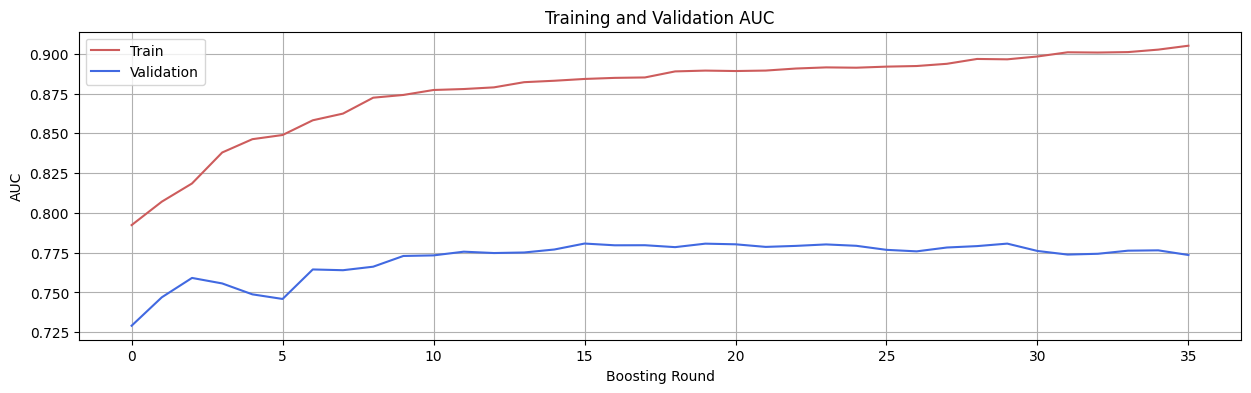

In [22]:
plot_metric(evals_result, "auc")

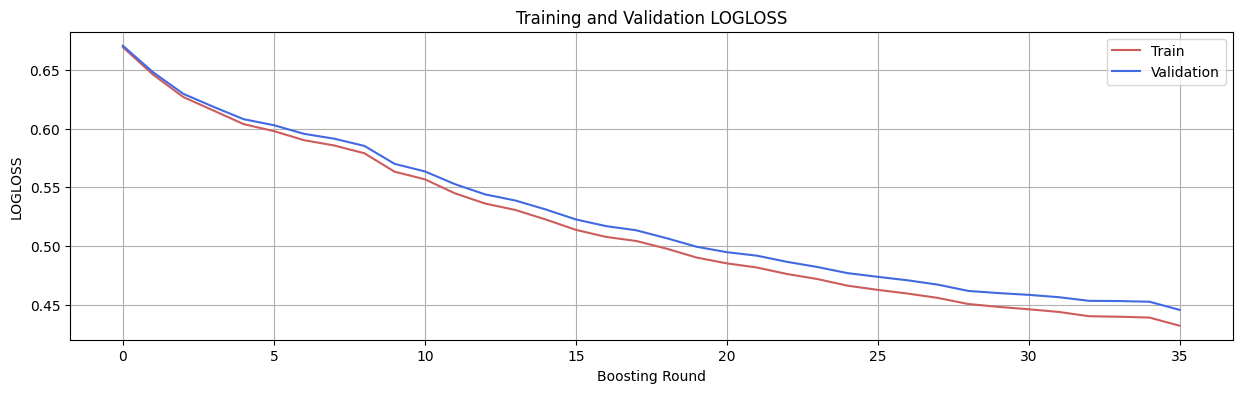

In [23]:
plot_metric(evals_result, "logloss")

In [24]:
"""
# Evaluation: ROC AUC Curve
"""

'\n# Evaluation: ROC AUC Curve\n'

In [25]:
X_test, y_test = split_features_and_response(test)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [26]:
y_pred = model.predict(dtest, output_margin=False)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)

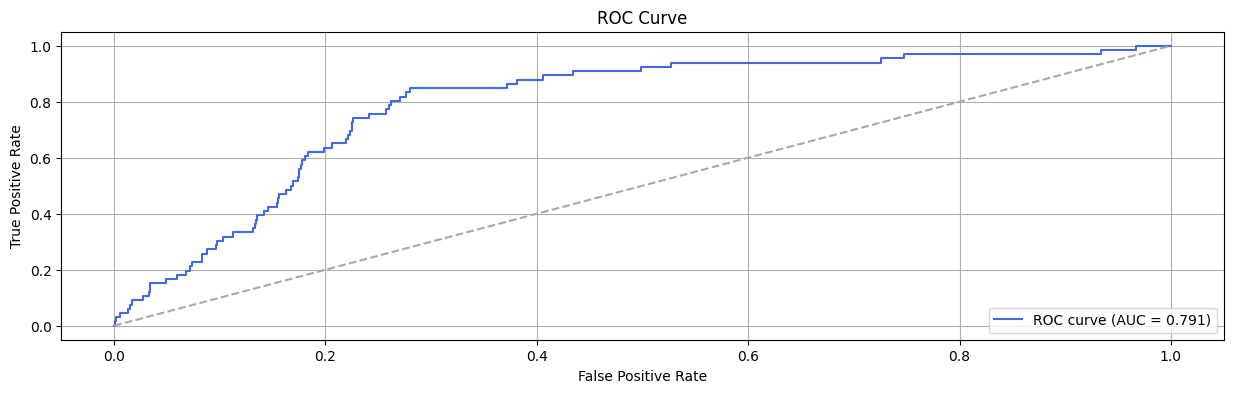

In [31]:
plt.figure(figsize=(15, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})", color="royalblue")
plt.plot([0, 1], [0, 1], linestyle="--", color="darkgray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

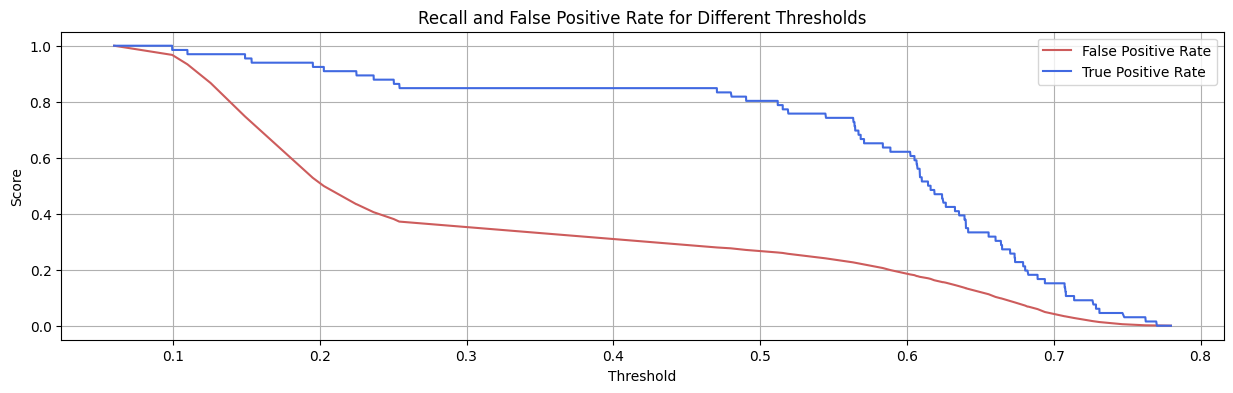

In [33]:
plt.figure(figsize=(15,4))
plt.plot(thresholds, fpr, label="False Positive Rate", color="indianred")
plt.plot(thresholds, tpr, label="True Positive Rate", color="royalblue")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Recall and False Positive Rate for Different Thresholds")
plt.legend()
plt.grid()
plt.show()